<span style="font-size:15pt;">ПРОЕКТ: принятие решений в бизнесе</span>

#### Описание

Я аналитик крупного интернет-магазина. Вместе с отделом маркетинга я подготовила список гипотез для увеличения выручки.
Нужно приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. Нужно построить графики, чтобы сравнить результаты тестов, посчитать статистическую значимость между группами данных, посмотреть, насколько различаются сырые данные и данные, очищенные от выбросов.

Описание данных

Данные для первой части:
Файл hypothesis
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


Данные для второй части
Файл orders
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл visitors
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста


#### Подгружаю библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import seaborn as sns

#### Загружаю датафреймы

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [3]:
orders = pd.read_csv('/datasets/orders.csv')

In [4]:
visitors = pd.read_csv('/datasets/visitors.csv')

In [5]:
def analyze_dataframes(dataframes):
    for df_name, df in dataframes.items():
        
        # Вывожу инфо о каждом датафрейме
        print(f"Info for DataFrame {df_name}:\n")
        df.info()
        print("\n" + "="*50 + "\n")  # Для разделения вывода

        # Вывожу describe для каждого датафрейма
        print(f"Describe for DataFrame {df_name}:\n")
        print(df.describe())
        print("\n" + "="*50 + "\n")  # Для разделения вывода

        # Считаю количество пропущенных значений
        print(f"Missing Values in DataFrame {df_name}:\n")
        missing_values = df.isnull().sum()
        print(missing_values)
        print("\n" + "="*50 + "\n")  # Для разделения вывода

        # Вывожу первые строки датафрейма
        print(f"Head of DataFrame {df_name}:\n")
        print(df.head())
        print("\n" + "="*50 + "\n")  # Для разделения вывода

# Делаю словарь с датафреймами
dataframes = {
    "hypothesis": hypothesis,
    "orders": orders,
    "visitors": visitors
}

# Вызываю функцию
analyze_dataframes(dataframes)

Info for DataFrame hypothesis:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Describe for DataFrame hypothesis:

           Reach     Impact  Confidence    Efforts
count   9.000000   9.000000    9.000000   9.000000
mean    4.777778   4.777778    5.555556   4.888889
std     3.153481   3.192874    3.045944   2.803767
min     1.000000   1.000000    1.000000   1.000000
25%     3.000000   3.000000    3.000000   3.000000
50%     3.000000   3.000000    7.000000   5.000000
75%     8.000000   7.000000    8.000000   6.000000
max    10.000000  10.000000    9.000000  10.000000


Missing Values in DataFrame hypoth

Все норм, пропусков в датафреймах нет, тип данных почти везде ок, нужно только дату будет поменять с object на datetime

####  Приоритизация гипотез

##### Применю фреймворк ICE для приоритизации гипотез. Отсортирую их по убыванию приоритета.

In [6]:
pd.set_option('display.max_colwidth', False)

In [7]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

In [8]:
hypothesis_ice = hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

In [9]:
hypothesis_ice.round(2)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


- Здесь вижу, что <b> на первом месте акция, дающая скидку на товар в ДР</b>. Видимо, скидки - это один из самых привлекательных инструментов. 
- <b>На последнем месте - изменение цвета фона главной страницы</b>. Ну да, скидки кажутся (и есть) более привлекательными

##### Применю фреймворк RICE для приоритизации гипотез. Отсортирую их по убыванию приоритета.

In [10]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis_rice = hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

In [11]:
hypothesis_rice

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


##### Как изменилась приоритизация гипотез при применении RICE вместо ICE, почему так произошло?

- Произошли перестановки в топ-5 гипотез, но этот топ сохранился прежним. 
- Гипотеза 7 переместилась на 1-е место из-за того, что reach у нее самый высокий, и это добавило "очков" при расчетах. 
- Гипотеза 2 поднялась на 2 место опять же по причине высокого reach близок к 0, и тогда даже самая эффективная гипотеза не совсем оправдает ожидания, если ее применить на практике.
- Цвет фона, кстати, так и остался на последнем месте) 

#### Анализ A/B-теста

переведу дату в orders формат datetime

In [12]:
orders['date'] = pd.to_datetime(orders['date'])

переведу дату в visitors в формат datetime

In [13]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [14]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

В тесте у нас две группы - А и В.

In [15]:
start_date = orders['date'].min()
end_date = orders['date'].max()

In [16]:
print(f"Дата начала теста: {start_date}")
print(f"Дата окончания теста: {end_date}")

Дата начала теста: 2019-08-01 00:00:00
Дата окончания теста: 2019-08-31 00:00:00


Посмотрим, не попадают ли пользователи в обе группы

In [17]:
visitor_group_counts = orders.groupby('visitorId')['group'].nunique()

# Выбираю пользователей, у которых более одной уникальной группы
users_in_multiple_groups = visitor_group_counts[visitor_group_counts > 1]

# Вывожу информацию о пользователях, попавших в обе группы в разных заказах
if not users_in_multiple_groups.empty:
    print("Пользователи, попавшие в обе группы в разных заказах:")
    print(users_in_multiple_groups)
else:
    print("Нет пользователей, попавших в обе группы в разных заказах.")

Пользователи, попавшие в обе группы в разных заказах:
visitorId
8300375       2
199603092     2
232979603     2
237748145     2
276558944     2
351125977     2
393266494     2
457167155     2
471551937     2
477780734     2
818047933     2
963407295     2
1230306981    2
1294878855    2
1316129916    2
1333886533    2
1404934699    2
1602967004    2
1614305549    2
1648269707    2
1668030113    2
1738359350    2
1801183820    2
1959144690    2
2038680547    2
2044997962    2
2378935119    2
2458001652    2
2579882178    2
2587333274    2
2600415354    2
2654030115    2
2686716486    2
2712142231    2
2716752286    2
2780786433    2
2927087541    2
2949041841    2
2954449915    2
3062433592    2
3202540741    2
3234906277    2
3656415546    2
3717692402    2
3766097110    2
3803269165    2
3891541246    2
3941795274    2
3951559397    2
3957174400    2
3963646447    2
3972127743    2
3984495233    2
4069496402    2
4120364173    2
4186807279    2
4256040402    2
4266935830    2
Name: gr

ага, интересно, и вот что мне с ними делать? 
логично было бы их все удалить, ведь мы не знаем, в какой группе тот или иной юзер точно состоял...
тогда, получается, этих юзеров нужно удалять и из orders и из visitors... покажу как я это сделала бы в следующей ячейке в NBconvert

Чтобы построить графики, нужно собрать кумулятивные данные

In [18]:
# создаю массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

Нужно собрать кумулятивные по дням данные о заказах 

In [19]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                                     orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 
      'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

Аналогично получаю агрегированные кумулятивные по дням данные о посетителях 

In [20]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                                         visitors['group'] == x['group'])]
                                       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), 
                                       axis=1).sort_values(by=['date','group']) 

Объединяю кумулятивные данные в одной таблице и присваиваю ее столбцам понятные названия

In [21]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], 
                                        right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [22]:
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [23]:
cumulativeData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   orders    62 non-null     int64         
 3   buyers    62 non-null     int64         
 4   revenue   62 non-null     int64         
 5   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 3.4+ KB


##### График кумулятивной выручки по группам. Выводы и предположения.

In [24]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

In [25]:
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

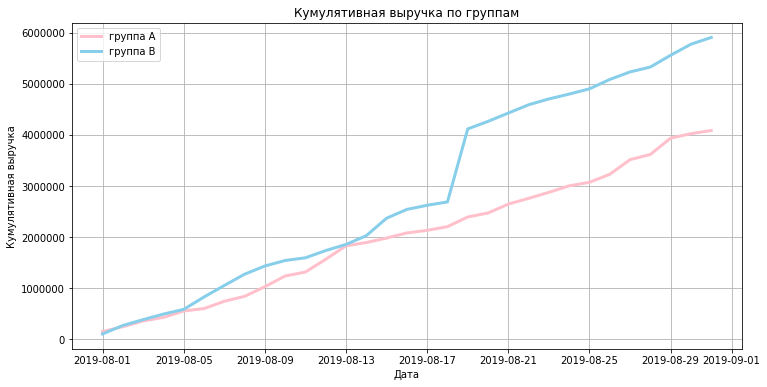

In [26]:
plt.figure(figsize=(12, 6))

# График выручки группы A 
plt.plot(cumulativeRevenueA['date'], 
         cumulativeRevenueA['revenue'], 
         label='группа A', 
         color='pink', 
         linewidth=3)

# График выручки группы B 
plt.plot(cumulativeRevenueB['date'], 
         cumulativeRevenueB['revenue'], 
         label='группа B', 
         color='skyblue', 
         linewidth=3)

plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.legend()
plt.ticklabel_format(axis = 'y', style = 'plain')
plt.grid(True)

plt.show()

- Выручка на обоих графиках увеличивается в течение теста. 
- Но график группы В резко растет 19 августа. Это может говорить о всплесках числа заказов либо о появлении очень дорогих заказов в выборке. 
- глядя на этот график, я могу сказать, что кумулятивная выручка в группе В больше, чем в А, и группа В по этому показателю побеждает группу А. 

##### График кумулятивного среднего чека по группам. Выводы и предположения.

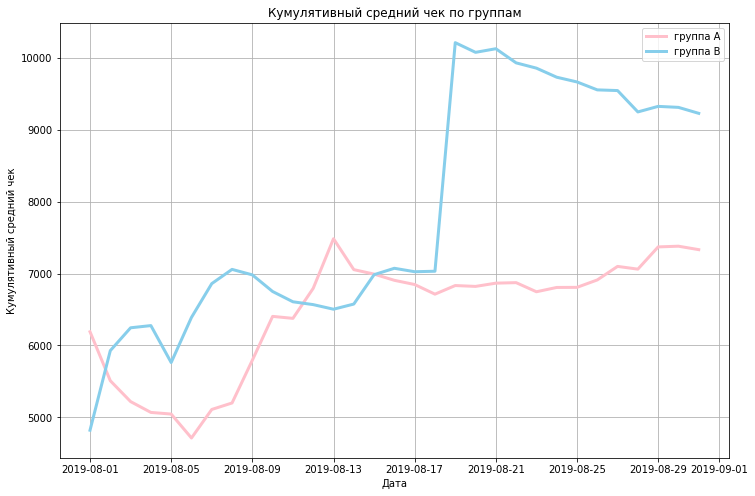

In [27]:
plt.figure(figsize=(12, 8)) 

# График кумулятивного среднего чека для группы A
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / 
         cumulativeRevenueA['orders'], label='группа A', color='pink', linewidth=3)

# График кумулятивного среднего чека для группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / 
         cumulativeRevenueB['orders'], label='группа B', color='skyblue', linewidth=3)

plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.legend()
plt.grid(True)  

plt.show()

- для группы А средний чек становится равномерным ближе к концу теста - линия более-менее прямая и есть небольшой рост
- снова видим, что то, что случилось 19 августа, вызвало очень сильный рост на графике для группы В, затем значение начало падать и продолжило падать до конца теста

##### График относительного изменения кумулятивного среднего чека группы B к группе A. Выводы и предположения.

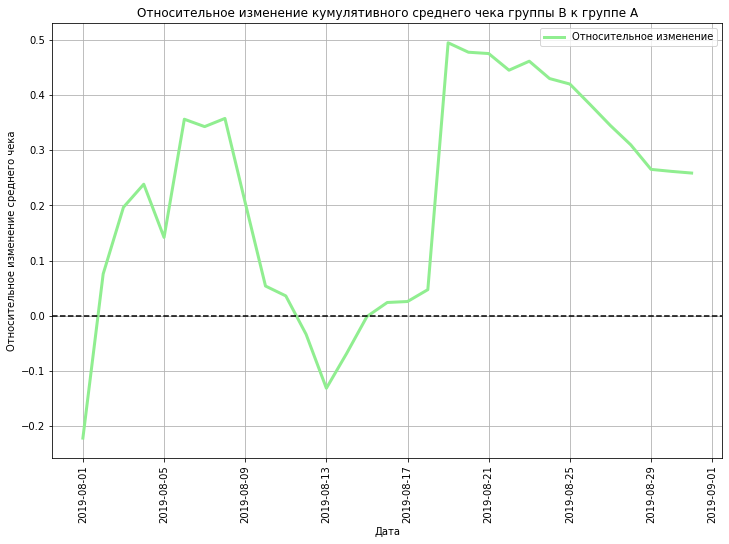

In [28]:
plt.figure(figsize=(12, 8))

# Собираю данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', 
                                                   right_on='date', how='left', suffixes=['A', 'B'])

# Строю отношение средних чеков с измененными параметрами
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) / 
         (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) - 1,
         color='lightgreen', label='Относительное изменение',  
         linewidth=3  
        )

# Добавляю ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.xticks(rotation=90)

plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение среднего чека')
plt.grid(True)
plt.legend()

plt.show()


- График скачет относительно нуля, но в целом я вижу, что средний чек в совокупности значений больше, чем у группы А
- Снова надо обратить внимание на событие 19 августа - тут тоже скачок

##### График кумулятивного среднего количества заказов на посетителя по группам. Выводы и предположения.

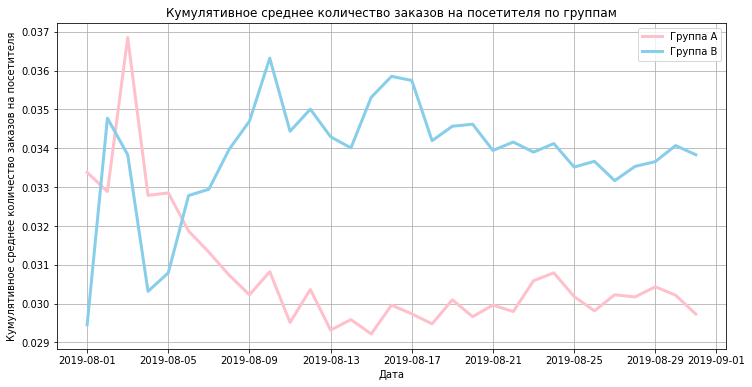

In [29]:
# Рассчитываю кумулятивное среднее количество заказов на посетителя для каждой группы
cumulativeData['cumulative_avg_orders_per_visitor'] = cumulativeData['orders'] / cumulativeData['visitors']

# Разделяю данные по группам
groupA_data = cumulativeData[cumulativeData['group'] == 'A']
groupB_data = cumulativeData[cumulativeData['group'] == 'B']

plt.figure(figsize=(12, 6))
plt.plot(groupA_data['date'], groupA_data['cumulative_avg_orders_per_visitor'], 
         label='Группа A', color='pink', linewidth=3)
plt.plot(groupB_data['date'], groupB_data['cumulative_avg_orders_per_visitor'], 
         label='Группа B', color='skyblue', linewidth=3)

plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее количество заказов на посетителя')
plt.legend()
plt.grid(True)

plt.show()


- группа В здесь снова превалирует после резкого скачка вверх начиная с 5 августа
- получается, что у группы В кумулятивное среднее кол-во заказов на посетителя примерно на 20% больше, чем у А

можно говорить о стабилизации результатов у обеих групп к концу теста

##### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Выводы и предположения.

In [30]:
cumulativeData

,date,group,orders,buyers,revenue,visitors,cumulative_avg_orders_per_visitor
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856
...,...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708,0.033657
58,2019-08-30,A,545,493,4022970,18037,0.030216
59,2019-08-30,B,620,567,5774631,18198,0.034070
60,2019-08-31,A,557,503,4084803,18736,0.029729


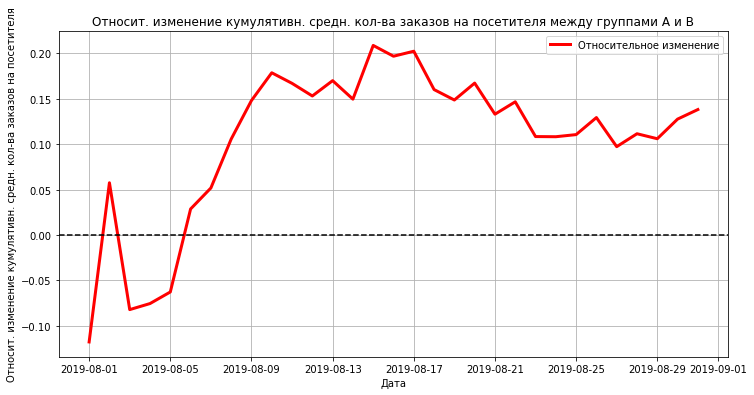

In [31]:
# Рассчитываю кумулятивное среднее количество заказов на покупателя для каждой группы
cumulativeData['cumulative_avg_orders_per_buyer'] = cumulativeData['orders'] / cumulativeData['visitors']

# Разделяю данные по группам
groupA_data = cumulativeData[cumulativeData['group'] == 'A']
groupB_data = cumulativeData[cumulativeData['group'] == 'B']

# Объединяю данные в одном датафрейме
mergedCumulativeOrders = groupA_data[['date', 'cumulative_avg_orders_per_buyer']].merge(
    groupB_data[['date', 'cumulative_avg_orders_per_buyer']], 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B']
)

plt.figure(figsize=(12, 6))
plt.plot(mergedCumulativeOrders['date'], (mergedCumulativeOrders['cumulative_avg_orders_per_buyerB'] / 
                                          mergedCumulativeOrders['cumulative_avg_orders_per_buyerA']) - 1, 
         label='Относительное изменение', color='red', linewidth=3)

plt.axhline(y=0, color='black', linestyle='--')

plt.title('Относит. изменение кумулятивн. средн. кол-ва заказов на посетителя между группами A и B')
plt.xlabel('Дата')
plt.ylabel('Относит. изменение кумулятивн. средн. кол-ва заказов на посетителя')
plt.legend()
plt.grid(True)

plt.show()


- Относительное изменение кумулятивного среднего кол-ва заказов на посетителя для группы В хоть и было нестабильно в первые 5 дней, но затем постоянно было выше, чем для группы А, 
- и к концу теста скачки перестали быть такими сильными, можно просто сказать что группа В стабильно тут побеждает

##### Точечный график количества заказов по пользователям. Выводы и предположения.

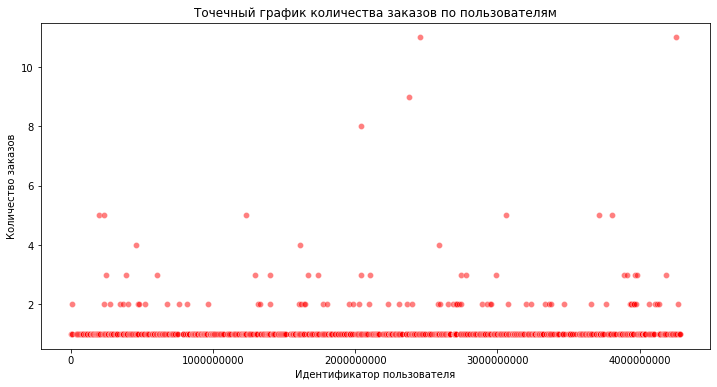

In [32]:
# Группирую данные по пользователям и считаю количество заказов
orders_per_user = orders.groupby('visitorId')['transactionId'].count().reset_index()
orders_per_user.columns = ['visitorId', 'orders_count']

plt.figure(figsize=(12, 6))
sns.scatterplot(x='visitorId', y='orders_count', data=orders_per_user, color='red', alpha=0.5)

plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Идентификатор пользователя')
plt.ylabel('Количество заказов')
plt.ticklabel_format(axis = 'x', style = 'plain')

plt.show()

In [33]:
value_counts_orders = orders_per_user['orders_count'].value_counts()

In [34]:
value_counts_orders

1     937
2     64 
3     17 
5     6  
4     3  
11    2  
8     1  
9     1  
Name: orders_count, dtype: int64

Вижу, что бОльшая часть юзеров сделала по одному заказу, много кто и по два, есть единицы тех, кто сделал по 5 заказов, остальное визуально определяю как выбросы, и value_counts это показывает

##### Считаю 95-й и 99-й перцентили количества заказов на пользователя. Выберу границу для определения аномальных пользователей.

In [35]:
orders_percentile_95 = np.percentile(orders_per_user['orders_count'], 95)
orders_percentile_99 = np.percentile(orders_per_user['orders_count'], 99)


print(f'95-й перцентиль: {orders_percentile_95}')
print(f'99-й перцентиль: {orders_percentile_99}')

95-й перцентиль: 2.0
99-й перцентиль: 4.0


здесь я бы удалила выбросы выше 99 перцентиля. те, кто сделал больше 4 заказов - точно выбросы

##### Точечный график стоимостей заказов. Сделайте выводы и предположения.

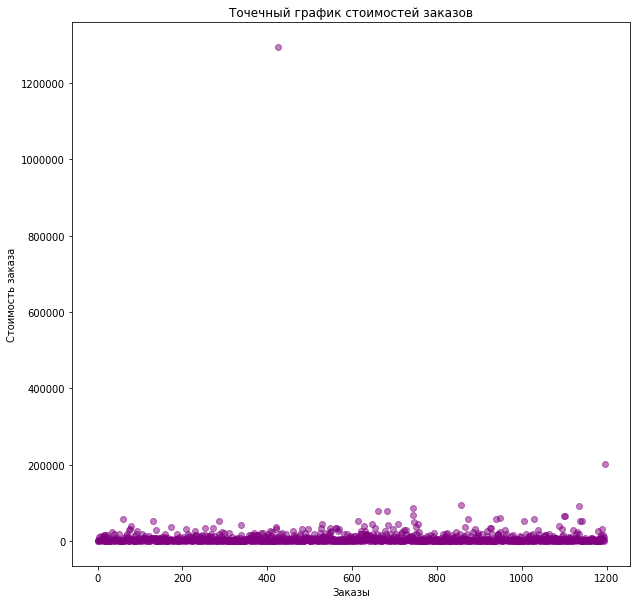

In [36]:
# Создаю Series для x_values
x_values = pd.Series(range(0, len(orders['revenue'])))

# Строю точечный график
plt.figure(figsize=(10, 10))
plt.scatter(x_values, orders['revenue'], color='purple', alpha=0.5)

# Настройка графика
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Заказы')
plt.ylabel('Стоимость заказа')
plt.ticklabel_format(axis='y', style='plain')  

plt.show()

- Тут явно видны выбросы, которые явно искажают картину и возможно влияют на среднее значение. От них точно предстоит избавиться
- в своей массе цены почти всех заказов точно лежат в пределах 50000

In [37]:
description = orders['revenue'].describe().apply(lambda x: format(x, ','))

In [38]:
description

count    1,197.0           
mean     8,348.005847953216
std      39,191.13177395123
min      50.0              
25%      1,220.0           
50%      2,978.0           
75%      8,290.0           
max      1,294,500.0       
Name: revenue, dtype: object

Да уж, при среднем около 3000, максимальное значение - 1294500 - это уж слишком. Когда удалю выбросы, среднее станет еще меньше.После удаления кстати будет интересно еще раз взглянуть на scatterplot

##### Считаю 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [39]:
revenue_percentile_95 = np.percentile(orders['revenue'], 95)
revenue_percentile_99 = np.percentile(orders['revenue'], 99)


print(f'95-й перцентиль: {revenue_percentile_95}')
print(f'99-й перцентиль: {revenue_percentile_99}')

95-й перцентиль: 28000.000000000004
99-й перцентиль: 58233.19999999999


Вот здесь я бы посчитала выбросами все что больше 95 перцентиля. 58000 это слишком много при таком небольшом среднем около 3к

##### Считаю статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Выводы и предположения.

Формулирую гипотезы:
- нулевая - различий в среднем кол-ве заказов на посетителя между группами нет
- альтернативная - различия в среднем кол-ве заказов на посетителя между группами есть

Для посдчета буду использовать тест Манна-Уитни.

In [40]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateA']
                                                  .sum() - len(ordersByUsersA['orders']))
                               , name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders']
                     ,pd.Series(0, index=np.arange(data['visitorsPerDateB']
                                                   .sum() - len(ordersByUsersB['orders']))
                                , name='orders')],axis=0) 


sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
p_value_order = stats.mannwhitneyu(sampleA, sampleB)[1]
relative_difference_order = sampleB.mean() / sampleA.mean() - 1

print(f"P-value: {p_value_order:.5f}")
alpha=0.05

if p_value_order < alpha:
    print("Есть статистически значимые различия между двумя группами.")
else:
    print("Нельзя говорить о том, что есть статистически значимые различия между двумя группами.")
print(f"Относительное различие: {relative_difference_order:.2%}")


P-value: 0.01679
Есть статистически значимые различия между двумя группами.
Относительное различие: 13.81%


- при p-value менее 0.05 можно говорить о том, что есть статистически значимые различия между двумя группами.
- это значит что среднее количество заказов на пользователя по группам значительно отличается
- различие составляет 13,8%

##### Считаю статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Выводы и предположения.

Формулирую гипотезы:
- нулевая - различий в среднем чеке заказа между группами нет
- альтернативная - различия в среднем чеке заказа на посетителя между группами есть

Для посдчета буду использовать тест Манна-Уитни.

In [41]:
p_value_revenue = stats.mannwhitneyu(
    orders[orders['group']=='A']['revenue'], 
    orders[orders['group']=='B']['revenue']
)[1]

relative_difference_revenue = (
    orders[orders['group']=='B']['revenue'].mean() /
    orders[orders['group']=='A']['revenue'].mean() - 1
)

# Проверка на статистическую значимость и вывод сообщения
alpha = 0.05
statistically_significant_revenue = p_value_revenue < alpha

# Вывод сообщений и результатов
if statistically_significant_revenue:
    print("Есть статистически значимые различия в выручке между двумя группами.")
else:
    print("Нельзя говорить о том, что есть статистически значимые различия в выручке между двумя группами.")

print(f"P-value для выручки: {p_value_revenue:.5f}")
print(f"Относительное различие в выручке: {relative_difference_revenue:.2%}")

Нельзя говорить о том, что есть статистически значимые различия в выручке между двумя группами.
P-value для выручки: 0.72929
Относительное различие в выручке: 25.87%


- статистически значимых различий в среднем чеке нет, т.к. p-value значительно больше, чем 0.05
- это значит что средний чек в двух группах равен

##### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Выводы и предположения.

Формулирую гипотезы:
- нулевая - различий в среднем кол-ве заказов на посетителя между группами нет
- альтернативная - различия в среднем кол-ве заказов на посетителя между группами есть

Для посдчета буду использовать тест Манна-Уитни.

In [42]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > orders_percentile_99]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_percentile_99]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_percentile_95]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)



sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


p_value_filtered = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
relative_difference_filtered = sampleBFiltered.mean() / sampleAFiltered.mean() - 1

alpha=0.05
statistically_significant_filtered = p_value_filtered < alpha


print(f"P-value для фильтрованных данных: {p_value_filtered:.5f}")
if statistically_significant_filtered:
    print("Есть статистически значимые различия между двумя группами (фильтрованные данные).")
else:
    print("Нельзя говорить о том, что есть статистически значимые различия между двумя группами (фильтрованные данные).")

print(f"Относительное различие для фильтрованных данных: {relative_difference_filtered:.2%}")

P-value для фильтрованных данных: 0.01846
Есть статистически значимые различия между двумя группами (фильтрованные данные).
Относительное различие для фильтрованных данных: 14.53%


- здесь есть статистически значимые различия, так как p-value меньше 0.05. значит среднее кол-во заказов на посетителя между группами достаточно сильно отличается
- данные очистили, а результат не поменялся. значит различия между группами по колву заказов есть
- группа В на 14,5% лучше группы А по кол-ву заказов

##### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным. Выводы и предположения.

Формулирую гипотезы:

- нулевая - различий в среднем чеке заказа между группами нет
- альтернативная - различия в среднем чеке заказа между группами есть

Для посдчета буду использовать тест Манна-Уитни.

In [43]:
p_value_filtered_revenue = float('{0:.3f}'.format(
    stats.mannwhitneyu(
        orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'],
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'],
    )[1]
))

relative_difference_filtered_revenue = (
    orders[
        np.logical_and(
            orders['group'] == 'B',
            np.logical_not(orders['visitorId'].isin(abnormalUsers)),
        )
    ]['revenue'].mean()
    / orders[
        np.logical_and(
            orders['group'] == 'A',
            np.logical_not(orders['visitorId'].isin(abnormalUsers)),
        )
    ]['revenue'].mean()
    - 1
)

alpha = 0.05
statistically_significant_filtered_revenue = p_value_filtered_revenue < alpha

print(f"P-value для фильтрованных данных по выручке: {p_value_filtered_revenue}")
if statistically_significant_filtered_revenue:
    print("Есть статистически значимые различия между двумя группами (фильтрованные данные по выручке).")
else:
    print("Нельзя говорить о том, что есть статистически значимые различия между двумя группами (фильтрованные данные по выручке).")

print(f"Относительное различие для фильтрованных данных по выручке: {relative_difference_filtered_revenue:.2%}")


P-value для фильтрованных данных по выручке: 0.961
Нельзя говорить о том, что есть статистически значимые различия между двумя группами (фильтрованные данные по выручке).
Относительное различие для фильтрованных данных по выручке: -1.38%


- так как p-value больше чем 0.05, можно сказать, что статистически значимых различий между группами нет, это значит, что средние чеки между группами по очищенным данным примерно одинаковы.
- здесь так же - данные очищены а результат не изменился.
- группа B хуже чем группа А по среднему чеку всего на 1,4 процента

##### Решение по результатам теста. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

Принимаю решение <b>Остановить тест, зафиксировать победу одной из групп.</b>

ВЫВОД И ОБОСНОВАНИЕ РЕШЕНИЯ 

после применения метода ICE, который учитывает воздействие на пользователя, уверенность в оценках других параметров, уровень трудности при оценке гипотезы: 

- лучшая гипотеза – запустить акцию, дающую скидку
- худшая – изменить цвет фона главной страницы


Но если учитывать не только эти параметры но и охват (использовать RICE), то тогда:
- лучшая гипотеза – добавить форму подписки
- худшая – все та же – изменить цвет фона главной страницы

по графикам:
- кумулятивная выручка по группам растет у обеих групп
- по кумулятивной выручке по сырым данным группа В побеждает
- кумулятивный средний чек для обеих групп постепенно растет
- по кумулятивному среднему чеку по сырым данным группа В снова побеждает
- кумулятивный средний чек у группы В по сырым данным больше, чем у группы А, в процессе теста он лишь ненадолго стал меньше, чем у группы А
- среднее кол-во заказов на посетителя по группампо сырым данным у группы В тоже больше
- по сырым данным относительное изменение кумулятивного среднего кол-ва заказов на посетителя для группы В также больше, чем для группы А
- на графиках с кол-вом заказов по пользователям и стоимости заказа были заметные выбросы, я их убрала 


по анализу А/В теста:
- по сырым данным среднее количество заказов на пользователя по группам значительно отличается. различие составляет 13,8%
- по очищенным данным среднее кол-во заказов на посетителя между группами достаточно сильно отличается. данные очистили, а результат не поменялся. значит различия между группами по колву заказов есть. группа В на 14% лучше группы А по кол-ву заказов
- статистически значимых различий в среднем чеке между группами по сырым данным нет
- средние чеки между группами по очищенным данным примерно одинаковы. здесь также данные очищены а результат не изменился. группа B хуже чем группа А по среднему чеку всего на 1,4 процента

Считаю, что тест можно остановить, тк группа В практически по всем покзателям лучше, чем группа А. 
- Хотя у группы В и случился один заказ на очень большую сумму и мы это посчитали выбросом, после его удаления результат группы В не стал хуже, чем у группы А. 
- Среднее кол-во заказов у группы В больше, хоть и группа В хуже чем группа А по среднему чеку. Зато у них заказов больше.
- если учитывать все выбросы, не удалять их (хотя анализировать их надо!), то группа В вообще по всем фронтам лидирует

!!! И я, кстати интересуюсь и ставлю под сомнение – а почему надо вообще очень дорогие заказы или людей с большим кол-вом заказов считать аномалиями? Если они есть, значит есть, не просто так они там появились (только если это не ошибка, конечно). я считаю, надо учитывать результаты и с выбросами, и без, и принимать решение где-то посередине. В моем случае я прихожу к выводу о победе группы В.  

